# Development of Deep Learning Model for Breast Cancer Detection using Histopathological Datasets.

## Motivation

Invase Ductual Carcinoma (IDC) is the most common types of Breast Cancer. It's malicious and able to form metastases which makes it especially dangerous. Often a Biopsy is done to remove small tissue samples. Then a pathologist has to decide whether a patient has IDC, another type of Breast Cancer or is healthy. In addition sick cells need to be located to find out how advanced the disease is and which grade should be assigned. This has to be done manually and is a time consuming process. Furthermore the decision depends on the expertise of the pathologist and his or her equipment. Therefor Deep Learning could be of great help to automatically detect and locate tumor tissue cells and to speed up the process. In order to exploit the full potential one could build a pipeline using massive amounts of tissue image data of various hospitals that were evaluated by different experts. This way one would be able to overcome the dependence on the pathologist which would be especially useful in regions where no experts are available .

## Our goal

The goal is to create a Deep Learning model that can be used to ease the work of the pathologist so that they can check the tissue samples in greater batches and in a more efficient manner.

This requires the model to be highly accurate and have good recall in both negative and postive classes.


## What is meant by invasive ductal carcinoma? <a class="anchor" id="intro"></a>

<a title="Mikael Häggström, M.D. - Author info - Reusing images [CC BY (https://creativecommons.org/licenses/by/2.5)]" href="https://commons.wikimedia.org/wiki/File:Lobules_and_ducts_of_the_breast.jpg"><img width="309" alt="Lobules and ducts of the breast" style="float:left; margin:0px 15px 15px 15px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Lobules_and_ducts_of_the_breast.jpg/256px-Lobules_and_ducts_of_the_breast.jpg"></a>


This illustration created [Mikael Häggström](https://commons.wikimedia.org/wiki/File:Lobules_and_ducts_of_the_breast.jpg) shows the anatomy of a healthy breast. One can see the lobules, the glands that can produce milk which flews through the milk ducts. Ductal carcinoma starts to develop in the ducts whereas lobular carcinoma has its origin in the lobules. Invasive carcinoma is able to leave its initial tissue compartment and can form metastases. 

In [1]:
#importing necissary libraries

from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
from os import listdir
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from skimage.io import imread
import itertools
import shutil
import matplotlib.pyplot as plt
import seaborn as sns


## Exploring the Data Structure

In [2]:
files = listdir(r"C:/Users/zionv\Downloads/YT test Dataset")
print(len(files))

6


In [3]:
#looking at first 5 folders
files[0:5]

['9346', '9347', '9381', '9382', '9383']

#### In each folder there are several images and each folder name is the id of the patient

In [4]:
base_path = r"C:/Users/zionv/Downloads/YT test Dataset/IDC_regular_ps50_idx5 test/"
folder = listdir(base_path)


#### We have to find the number of total images in the dataset

In [5]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id
        class_path = patient_path + '/' + str(c) + '/'
        subfiles = listdir(class_path)
        total_images += len(subfiles)
        
print("Total Images in dataset: ", total_images )

Total Images in dataset:  5313


#### Organizing the data into pandas data frame

In [6]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()


,patient_id,path,target
0,9346,C:/Users/zionv/Downloads/YT test Dataset/IDC_r...,0
1,9346,C:/Users/zionv/Downloads/YT test Dataset/IDC_r...,0
2,9346,C:/Users/zionv/Downloads/YT test Dataset/IDC_r...,0
3,9346,C:/Users/zionv/Downloads/YT test Dataset/IDC_r...,0
4,9346,C:/Users/zionv/Downloads/YT test Dataset/IDC_r...,0


#### Shape of data frame[](http://)

### Insights

* The numbe rof image patches per patient varie's a lot.

* Some patients have more than 80 % patches that show IDC! Consequently the tissue is full of cancer or only a part of the breast was covered by the tissue slice that is focused on the IDC cancer. 

* The classes of IDC versus no IDC are imbalanced.

In [7]:
# coverting target to int
data.target = data.target.astype(int)

### Displaying Cancer Tissue Samples

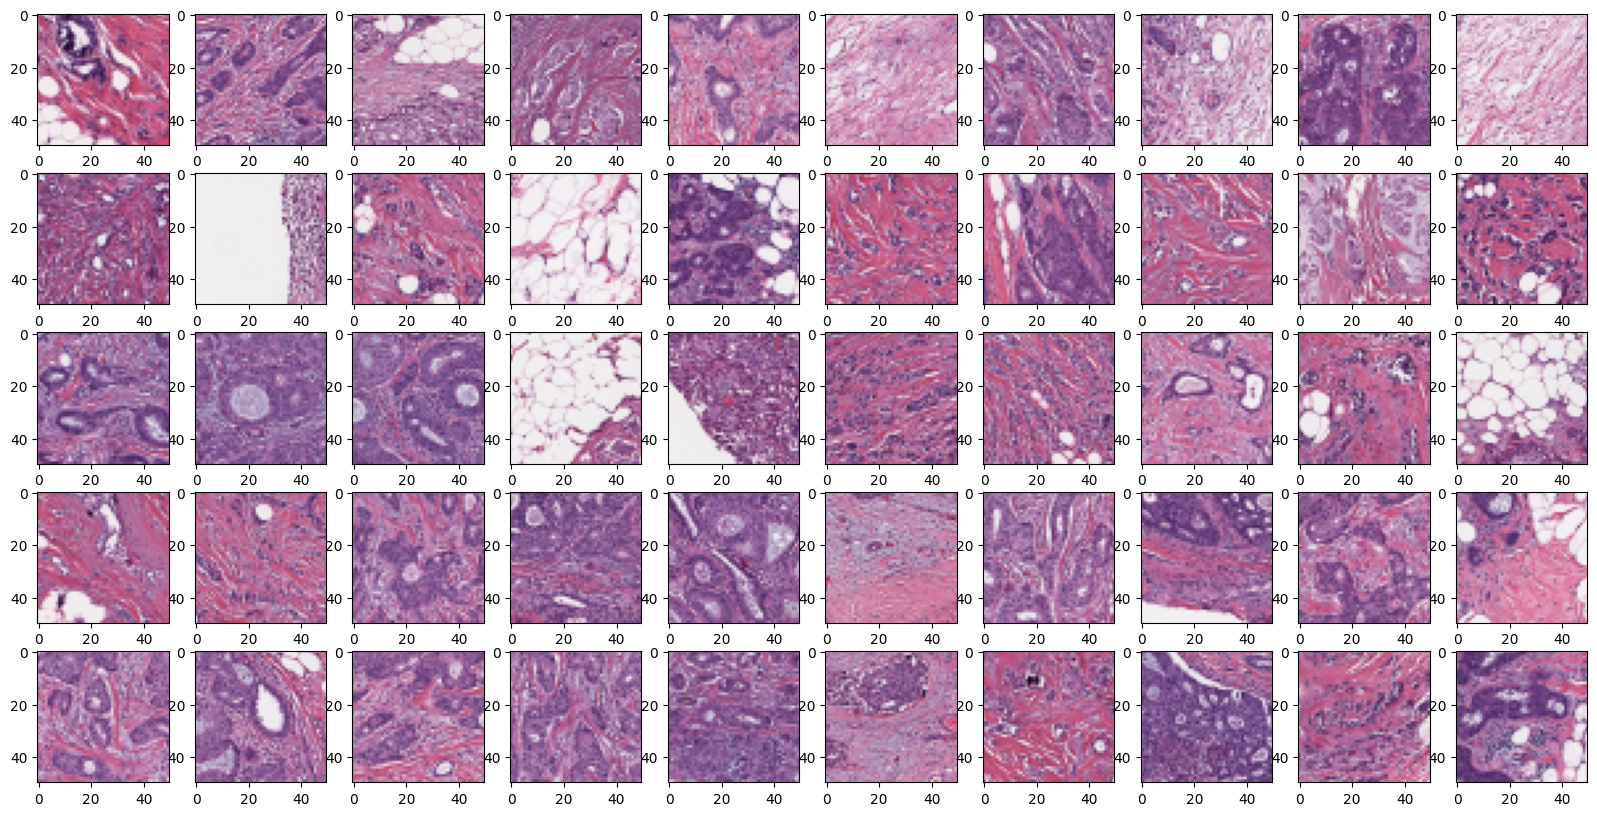

In [8]:
cancer_selection = np.random.choice(data[data.target == 1].index.values, size=50, replace=False)

fig, ax = plt.subplots(5, 10, figsize=(20, 10))

for n in range(5):
    for m in range(10):
        idx = cancer_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)


### Displaying Non-Cancer Tissue Samples

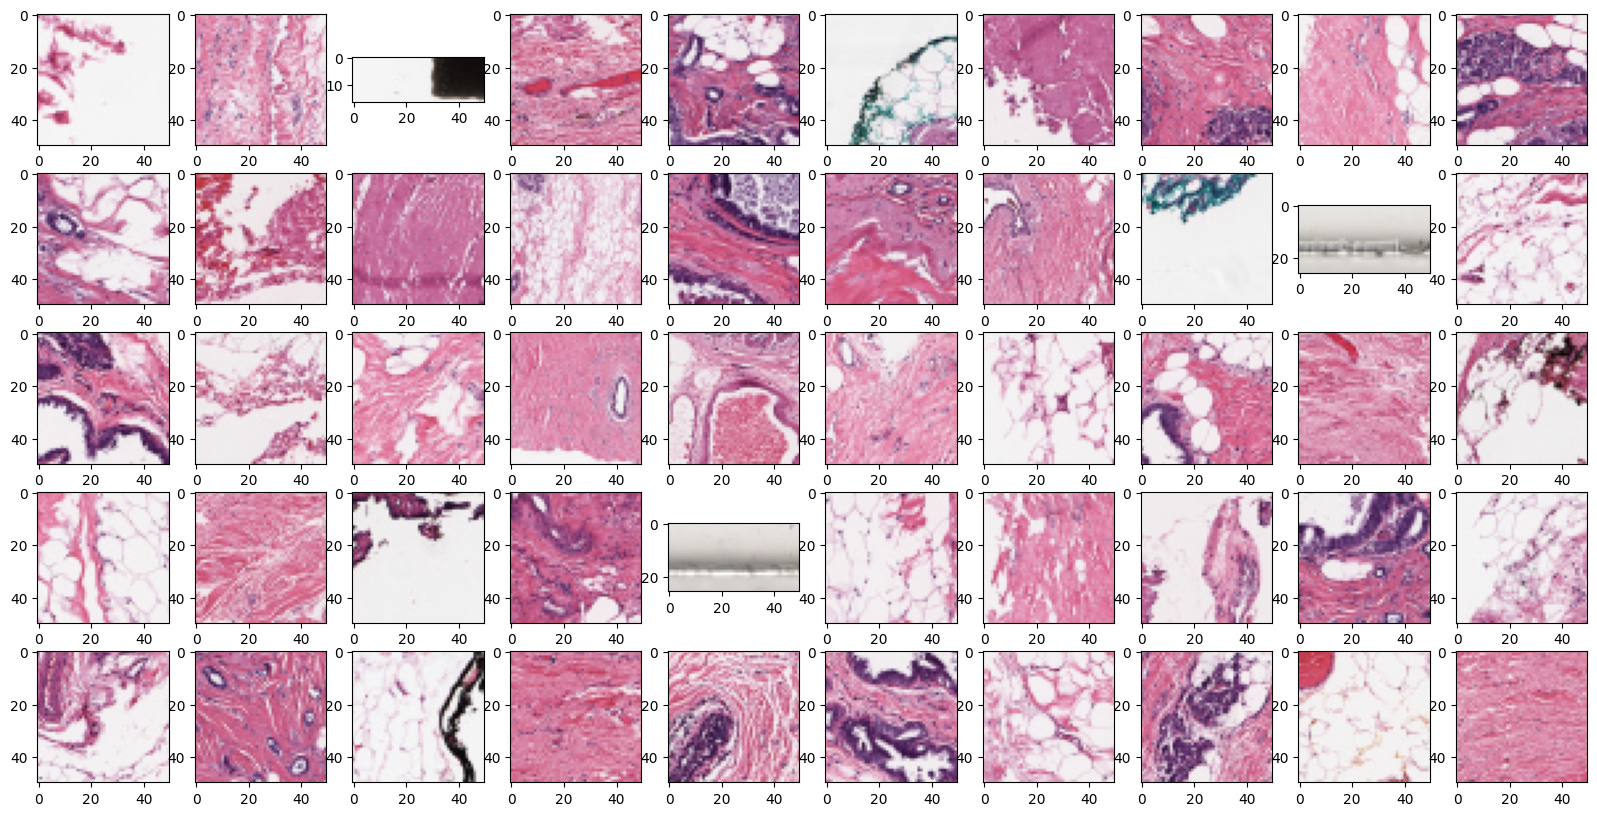

In [9]:
non_cancer_selection = np.random.choice(data[data.target == 0].index.values, size=50, replace=False)

fig, ax = plt.subplots(5, 10, figsize=(20, 10))

for n in range(5):
    for m in range(10):
        idx = non_cancer_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

### Insights

* Cancer Tissue appears to be more violet.

* But some non-cancer tissue is also violet.


## Preparing the dataset

In [10]:
# Creating diresctory to store all images
all_images_dir_test = 'all_images_dir_test'

if os.path.isdir(all_images_dir_test):
    pass
else:
    os.mkdir(all_images_dir_test)
    


In [11]:
# This code copies all images from their seperate folders into the same 
# folder called all_images_dir.

'''
The directory structure is like:
    patient_id:
                0
                1
'''

patient_list = folder

for patient in patient_list:
    
    path_0 = r"C:/Users/zionv/Downloads/Yt Dataset/IDC_regular_ps50_idx5/" + str(patient) + '/0'
    path_1 = r"C:/Users/zionv/Downloads/Yt Dataset/IDC_regular_ps50_idx5/" + str(patient) + '/1'
    
    # create list of all files in folder 0
    file_list_0 = listdir(path_0)
    
    #create a list of all files in folder 1
    file_list_1 = listdir(path_1)
    
    # moving the 0 class images to all_images_dir
    for fname in file_list_0:
        
        src = os.path.join(path_0, fname)
        dst = os.path.join(all_images_dir_test, fname)
        shutil.copyfile(src, dst)
        
    # moving the 1 class images to all_images_dir
    for fname in file_list_1:
        
        src = os.path.join(path_1, fname)
        dst = os.path.join(all_images_dir_test, fname)
        shutil.copyfile(src, dst)

    
        

In [12]:
# Total number of images
len(listdir(all_images_dir_test))

5313

### Creating dataframe of all images

In [13]:
image_list = os.listdir('all_images_dir_test')
df_data = pd.DataFrame(image_list, columns=['image_id'])

df_data.head()

,image_id
0,9346_idx5_x1001_y1001_class0.png
1,9346_idx5_x1001_y1051_class0.png
2,9346_idx5_x1001_y1101_class0.png
3,9346_idx5_x1001_y1151_class0.png
4,9346_idx5_x1001_y1201_class0.png


In [14]:
# Defining helper functions

def extract_patient_id(x):
    
    a = x.split('_')
    patient_id = a[0]
    
    return patient_id

def extract_target(x):
    
    a = x.split('_')
    b = a[4]
    target = b[5]
    
    return target

# creating new column named patient_id
df_data['patient_id'] = df_data['image_id'].apply(extract_patient_id)

#creating new column named target
df_data['target'] = df_data['image_id'].apply(extract_target)

df_data.head(10)

    

,image_id,patient_id,target
0,9346_idx5_x1001_y1001_class0.png,9346,0
1,9346_idx5_x1001_y1051_class0.png,9346,0
2,9346_idx5_x1001_y1101_class0.png,9346,0
3,9346_idx5_x1001_y1151_class0.png,9346,0
4,9346_idx5_x1001_y1201_class0.png,9346,0
5,9346_idx5_x1001_y1251_class1.png,9346,1
6,9346_idx5_x1001_y1301_class1.png,9346,1
7,9346_idx5_x1001_y1351_class1.png,9346,1
8,9346_idx5_x1001_y1401_class1.png,9346,1
9,9346_idx5_x1001_y1451_class1.png,9346,1


In [15]:
# class distribution of the images

df_data['target'].value_counts()

target
0    3991
1    1322
Name: count, dtype: int64

### Balance the class distribution

* We can see that the class 1 images are higher in number that of class 0

* So to prevent this we balance the dataset

* We do this so that the Neural Network dose not lean on favouring only one class 

In [16]:
SAMPLE_SIZE = 1322

# take a sample of the majority class 0 (total = 198738)
df_0 = df_data[df_data['target'] == '0'].sample(SAMPLE_SIZE, random_state=101)
# take a sample of class 1 (total = 78786)
df_1 = df_data[df_data['target'] == '1'].sample(SAMPLE_SIZE, random_state=101)

# concat the two dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

# Check the new class distribution
df_data['target'].value_counts()

target
0    1322
1    1322
Name: count, dtype: int64

### Creating train and test sets

In [17]:
y = df_data['target']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)



### Creating Directory Structure

In [18]:
'''
#ALready created
# Creating new base directory

base_dir_test ='base_dir_test'
os.mkdir(base_dir_test)

# Creating train directory inside base directory
train_dir = os.path.join(base_dir_test, 'train_dir')
os.mkdir(train_dir)

# Creating validation directory inside base directory
val_dir = os.path.join(base_dir_test, 'val_dir')
os.mkdir(val_dir)

# create new folders inside train_dir
a_no_idc = os.path.join(train_dir, 'a_no_idc')
os.mkdir(a_no_idc)
b_has_idc = os.path.join(train_dir, 'b_has_idc')
os.mkdir(b_has_idc)


# create new folders inside val_dir
a_no_idc = os.path.join(val_dir, 'a_no_idc')
os.mkdir(a_no_idc)
b_has_idc = os.path.join(val_dir, 'b_has_idc')
os.mkdir(b_has_idc)
'''



"\n#ALready created\n# Creating new base directory\n\nbase_dir_test ='base_dir_test'\nos.mkdir(base_dir_test)\n\n# Creating train directory inside base directory\ntrain_dir = os.path.join(base_dir_test, 'train_dir')\nos.mkdir(train_dir)\n\n# Creating validation directory inside base directory\nval_dir = os.path.join(base_dir_test, 'val_dir')\nos.mkdir(val_dir)\n\n# create new folders inside train_dir\na_no_idc = os.path.join(train_dir, 'a_no_idc')\nos.mkdir(a_no_idc)\nb_has_idc = os.path.join(train_dir, 'b_has_idc')\nos.mkdir(b_has_idc)\n\n\n# create new folders inside val_dir\na_no_idc = os.path.join(val_dir, 'a_no_idc')\nos.mkdir(a_no_idc)\nb_has_idc = os.path.join(val_dir, 'b_has_idc')\nos.mkdir(b_has_idc)\n"

In [19]:
# check that the folders have been created
os.listdir('base_dir_test/train_dir')

['a_no_idc', 'b_has_idc']

In [20]:
# Set the id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [21]:

train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

# Transfering the train images
for image in train_list:

    try: 
        fname = image
        target = df_data.loc[image, 'target']

        if target == '0':
            label = 'a_no_idc'
        if target == '1':
            label = 'b_has_idc'

        # source path to image
        src = os.path.join(all_images_dir_test, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # move the image from the source to the destination
        shutil.move(src, dst)
    except: 
        continue

for image in val_list:

    try: 
        fname = image
        target = df_data.loc[image,'target']

        if target == '0':
            label = 'a_no_idc'
        if target == '1':
            label = 'b_has_idc'


        # source path to image
        src = os.path.join(all_images_dir_test, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # move the image from the source to the destination
        shutil.move(src, dst)

    except:
        continue

        

In [22]:
# check how many val images we have in each folder
print(len(os.listdir('base_dir_test/train_dir/a_no_idc')))
print(len(os.listdir('base_dir_test/train_dir/b_has_idc')))

1190
1189


### Setting up image generators

In [23]:
train_path = 'base_dir_test/train_dir'
valid_path = 'base_dir_test/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [24]:
IMAGE_SIZE = 50

In [25]:

datagen = ImageDataGenerator(rescale = 1.0 / 255,
                             rotation_range = 90,
                             zoom_range = 0.2,
                             horizontal_flip=True,
                             vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 2379 images belonging to 2 classes.
Found 265 images belonging to 2 classes.
Found 265 images belonging to 2 classes.


In [26]:
# Building the model
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()

#The first convolutional layer with 32 filters
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

# The second convolutional layer with Three convolutional layers with 64 filters each.
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# The third convolutional layer with Three convolutional layers with 128 filters each.
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 64)        18496     
                                                        

### Training the model

In [27]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

filepath = "model_test.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, 
                              verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=9, verbose=1,
                    callbacks=callbacks_list)

try:
    model.save('model_test.h5')
except:
    pass

try: 
    model.save('model_test.h5')
except:
    pass


Epoch 1/9
238/238 [==============================] - ETA: 0s - loss: 0.5766 - accuracy: 0.6646
Epoch 1: val_accuracy improved from -inf to 0.83774, saving model to model_test.h5
238/238 [==============================] - 34s 137ms/step - loss: 0.5766 - accuracy: 0.6646 - val_loss: 0.4324 - val_accuracy: 0.8377 - lr: 1.0000e-04
Epoch 2/9
237/238 [============================>.] - ETA: 0s - loss: 0.3682 - accuracy: 0.8594
Epoch 2: val_accuracy improved from 0.83774 to 0.87170, saving model to model_test.h5
238/238 [==============================] - 15s 63ms/step - loss: 0.3678 - accuracy: 0.8596 - val_loss: 0.3484 - val_accuracy: 0.8717 - lr: 1.0000e-04
Epoch 3/9
238/238 [==============================] - ETA: 0s - loss: 0.3260 - accuracy: 0.8764
Epoch 3: val_accuracy did not improve from 0.87170
238/238 [==============================] - 15s 63ms/step - loss: 0.3260 - accuracy: 0.8764 - val_loss: 0.3081 - val_accuracy: 0.8717 - lr: 1.0000e-04
Epoch 4/9
238/238 [=========================

In [29]:
model.save('model_test.h5')

### Evaluating the model

In [30]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [31]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate(test_gen, 
                steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)


265/265 [==============================] - 1s 4ms/step - loss: 0.2757 - accuracy: 0.8943
val_loss: 0.2756679952144623
val_acc: 0.8943396210670471


### Make a prediction on the val set
We need these predictions to calculate the AUC score, print the Confusion Matrix and calculate the F1 score.

In [32]:
# make a prediction
predictions = model.predict(test_gen, steps=len(df_val), verbose=1)


265/265 [==============================] - 2s 6ms/step


In [33]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

{'a_no_idc': 0, 'b_has_idc': 1}

In [34]:
# Put the predictions into a dataframe.
# The columns need to be oredered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['no_idc', 'has_idc'])

df_preds.head()

,no_idc,has_idc
0,0.997637,0.002363
1,0.975853,0.024147
2,0.994751,0.005249
3,0.990578,0.009421
4,0.998760,0.001240


In [35]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_idc']

### Calculating the AUC Score

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.9548302574618364

### Creating the confusion matrix

In [37]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')
        
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
        

In [38]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [39]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [40]:
# Print the label associated with each class
test_gen.class_indices

{'a_no_idc': 0, 'b_has_idc': 1}

Confusion matrix
[[120  12]
 [ 16 117]]


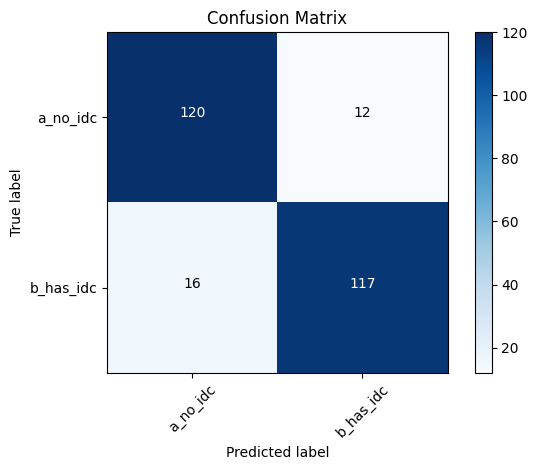

In [41]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['a_no_idc', 'b_has_idc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Creating a classfifcation Report

In [42]:
from sklearn.metrics import classification_report

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

    a_no_idc       0.88      0.91      0.90       132
   b_has_idc       0.91      0.88      0.89       133

    accuracy                           0.89       265
   macro avg       0.89      0.89      0.89       265
weighted avg       0.89      0.89      0.89       265



**Recall** = Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.<br>
**Support**= Number of true instances in each class

### Conclusion

* From the above report we can see that the model gives us admirable results.

* The model can be improved.

* The recall for each class should be ideally be above 0.85

* The present recall which the model produces is good enough.

* For use in the real world the recall can be further improved.

* This model can help pathologists detect cancer on tissue faster

* The manual examining of tissue slides would not be required